## This notebook uses the relations in Chaplin et al. 2011 to prediction the detection probability of stars a s function of Kepler magnitude.

In [ ]:
import numpy as np
import scipy.stats as stats
from matplotlib.pyplot import *

In [3]:
def seismicParameters(teff, lum):

    # solar parameters
    teff_solar = 5777.0 # Kelvin
    teffred_solar = 8907.0 #Kelvin
    numax_solar = 3090.0 # muHz
    dnu_solar = 135.1 # muHz

 
    
    teffred = teffred_solar*(lum**-0.093) # from (6) eqn 8. red-edge temp
    
    rad = lum**0.5 * ((teff/teff_solar)**-2) # Steffan-Boltzmann law
    
    numax = numax_solar*(rad**-1.85)*((teff/teff_solar)**0.92) # from (14)

    return rad, numax, teffred, teff_solar, teffred_solar, numax_solar, dnu_solar

def globalDetections(cadence, kmag, rad, teff, numax, T, teffred, teff_solar, teffred_solar, numax_solar, 
                      dnu_solar, dilution, vary_beta=False, fap = 0.05, noiseOffset=0):
    
    vnyq = (1.0 / (2.0*cadence)) * 10**6 # in micro Hz

    eta = np.sinc(numax/(2*vnyq))

    Pgrantotal = 0.1*(numax/numax_solar)**(-2)
    
    # P_envelope    
    beta = 1.0-np.exp(-(teffred-teff)/1550) # beta correction for hot solar-like stars from (6) eqn 9.
      
    ptot = 255 * beta**2 * eta**2 * rad**3.5 * (teff/teff_solar)**1.25 # units ppm**2

    # Instrumental
    c = 1.28*10**(0.4*(12-kmag)+7)
    n = 1e6/c * np.sqrt(c + 9.5e5 * (14/kmag)**5)  
    Binstr = 2e-6 * n**2 * cadence  + noiseOffset# units are ppm**2/muHz
       
    bgtot = (Binstr + Pgrantotal) * numax # units are ppm**2

    snr = ptot/bgtot # global signal to noise ratio from (11)
        
    tlen = T*86400.0 # Length of observations in seconds
    
    bin_width= 1e6 / tlen
    
    nbins = int((numax*tlen/1e6))
    
    snrthresh = stats.chi2.ppf(1.0 - fap, 2*nbins) / (2*nbins) - 1
        
    pfinal = stats.chi2.sf((snrthresh+1) / (snr+1)*2*nbins, 2*nbins)
    
    return pfinal

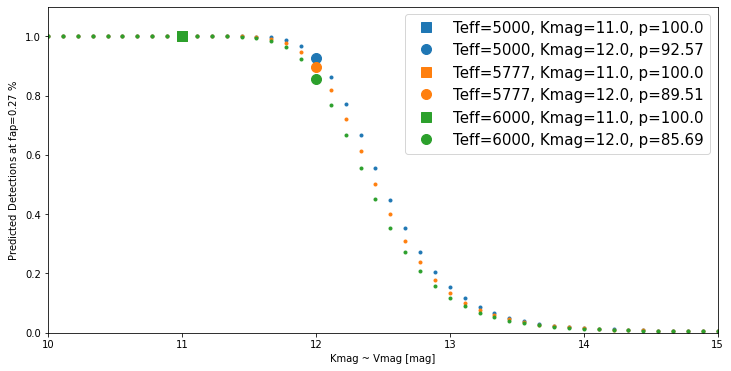

In [6]:
T = 365 # year
cadence = 21 # Kepler cadence (s)

fig, ax = subplots(figsize = (12,6))
cols = ['C0', 'C1', 'C2']
shap = ['s', 'o']

fap = 1-0.9973
for i, teff in enumerate([5000, 5777, 6000]):
    rad, numax, teffred, teff_solar, teffred_solar, numax_solar, dnu_solar = seismicParameters(teff=teff, lum=(teff/5777)**4)

    for kmag in np.linspace(6, 17, 100):
        p = globalDetections(cadence, kmag, rad, teff, numax, T, teffred, teff_solar, teffred_solar, numax_solar, 
                             dnu_solar, dilution=1, vary_beta=False, fap=fap, noiseOffset=0.8)
        ax.plot(kmag, p, '.', color = cols[i])
        
        if kmag in [11, 12]:
            ax.plot(kmag, p, shap[int(kmag)-11], ms = 10, color = cols[i], label = f'Teff={teff}, Kmag={kmag}, p={np.round(p*100, 2)}')
        
ax.legend(fontsize = 15)
ax.set_ylim(0,1.1)
ax.set_xlim(10,15)
ax.set_ylabel(f'Predicted Detections at fap={np.round(fap*100,3)} $\\%$')
ax.set_xlabel('Kmag ~ Vmag [mag]')
fig.savefig('Predicted_detection_probability.png')